In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                               roc_auc_score, confusion_matrix, classification_report, roc_curve)
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import warnings
warnings.filterwarnings('ignore')

# For handling imbalance
from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler # Consider this too for more complex imbalance handling
# from imblearn.pipeline import Pipeline # Useful for complex data processing pipelines

In [2]:
# Cell 2: Load Data
df = pd.read_csv("C:/Users/Anandu/Desktop/tcs/tele_data.csv")
print(df.head()) # [cite: 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [3]:
# Cell 3: Data Preprocessing and Feature Engineering
# Convert TotalCharges to numeric, handle errors
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])
df.reset_index(drop=True, inplace=True)

# Create AvgChargesPerMonth feature
df['AvgChargesPerMonth'] = df['TotalCharges'] / df['tenure']
df['AvgChargesPerMonth'].replace([np.inf, -np.inf], 0, inplace=True)
df['AvgChargesPerMonth'].fillna(0, inplace=True)

# Drop customerID if it exists
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)
else:
    print("Warning: 'customerID' column not found, skipping drop operation.")

# Feature Engineering (Examples - add more if relevant)
# Total number of services
df['TotalServices'] = (df[['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                           'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

# Binary flags for internet/phone service presence
df['HasInternet'] = df['InternetService'].apply(lambda x: 1 if x != 'No' else 0)
df['HasPhone'] = df['PhoneService'].apply(lambda x: 1 if x != 'No phone service' else 0)

# Encode target variable 'Churn'
le_churn = LabelEncoder()
df['Churn'] = le_churn.fit_transform(df['Churn']) # 'No' -> 0, 'Yes' -> 1

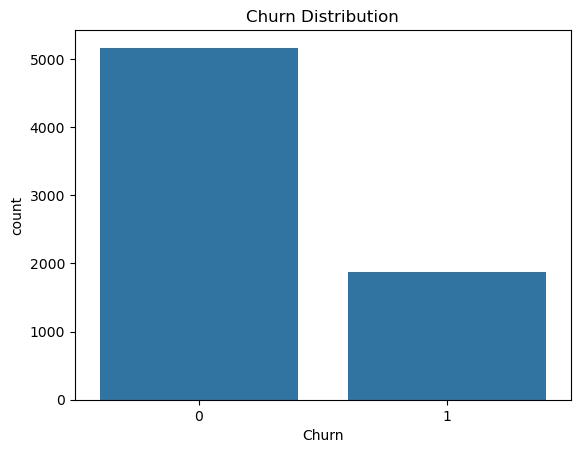

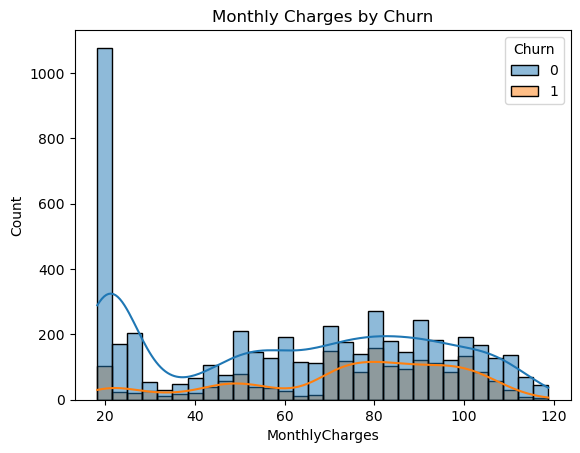

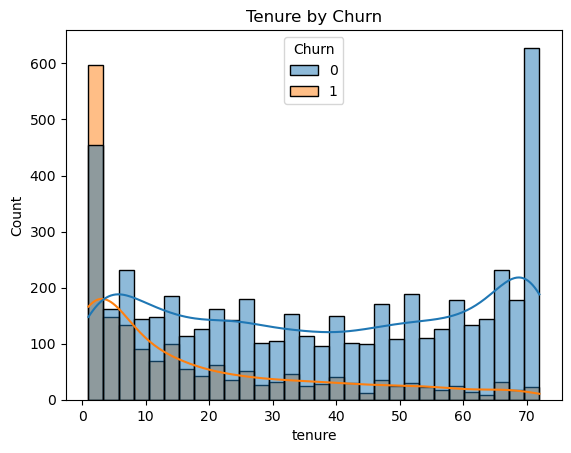

In [4]:
# Cell 4: Exploratory Data Analysis (EDA) - Visualizations
# Churn distribution
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

# Monthly Charges distribution by Churn
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', kde=True, bins=30)
plt.title('Monthly Charges by Churn')
plt.show()

# Tenure distribution by Churn
sns.histplot(data=df, x='tenure', hue='Churn', kde=True, bins=30)
plt.title('Tenure by Churn')
plt.show()

In [5]:
# Cell 5: Data Splitting, Categorical Encoding, and Scaling
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

# Apply Label Encoding to categorical features for TabNet
# TabNet expects categorical features to be integer encoded for its embeddings.
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Split data - BEFORE SMOTE, as SMOTE should only be applied to the training data to prevent data leakage.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale numerical features ONLY using StandardScaler
scaler = StandardScaler()

# Create copies to avoid modifying original dataframes directly for scaling
X_train_resampled_scaled = X_train_resampled.copy()
X_test_scaled = X_test.copy()

# Scale only numerical columns
X_train_resampled_scaled[numerical_cols] = scaler.fit_transform(X_train_resampled[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols]) # [cite: 14]

# TabNet requires numpy arrays for input
X_train_np = X_train_resampled_scaled.values
y_train_np = y_train_resampled.values
X_test_np = X_test_scaled.values
y_test_np = y_test.values

# Define categorical feature indices and dimensions for TabNet
# These indices are based on the column order in the final X_train_resampled_scaled DataFrame
cat_idxs = [X_train_resampled_scaled.columns.get_loc(col) for col in cat_cols]
cat_dims = [X_train_resampled_scaled[col].nunique() for col in cat_cols]

In [6]:
# Cell 6: TabNet Model Initialization and Training
tabnet_model = TabNetClassifier(
    verbose=1,
    seed=42,
    cat_idxs=cat_idxs,       # Indices of categorical features
    cat_dims=cat_dims,       # Number of unique categories for each categorical feature
    cat_emb_dim=2,           # Embedding dimension for categorical features (experiment with 1 or 2)
    n_d=16,                  # Dimensions of the decision prediction layer (experiment: 8, 16, 24, 32)
    n_a=16,                  # Dimensions of the attention embedding layer (experiment: 8, 16, 24, 32)
    n_steps=5,               # Number of decision steps in the TabNet architecture (experiment: 3 to 10)
    gamma=1.5,               # Relaxation parameter for attention (experiment: 1.0, 1.2, 1.5)
    lambda_sparse=1e-4,      # Sparsity regularization (experiment: 1e-3 to 1e-6)
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2), # Initial learning rate (experiment: 1e-2, 5e-3)
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params={"step_size":50, "gamma":0.9}, # Decrease LR by 0.9 every 50 epochs
    mask_type='sparsemax'    # Can also try 'entmax'
)

tabnet_model.fit(
    X_train_np, y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    eval_metric=['accuracy', 'auc'], # [cite: 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
    max_epochs=200, # Increased max_epochs to allow more training
    patience=30,    # Increased patience for early stopping [cite: 31]
    batch_size=1024,
    virtual_batch_size=128
)

epoch 0  | loss: 0.84153 | val_0_accuracy: 0.64392 | val_0_auc: 0.65356 |  0:00:00s
epoch 1  | loss: 0.58937 | val_0_accuracy: 0.67022 | val_0_auc: 0.69162 |  0:00:01s
epoch 2  | loss: 0.54718 | val_0_accuracy: 0.6425  | val_0_auc: 0.69381 |  0:00:02s
epoch 3  | loss: 0.52942 | val_0_accuracy: 0.68159 | val_0_auc: 0.74465 |  0:00:03s
epoch 4  | loss: 0.50871 | val_0_accuracy: 0.61976 | val_0_auc: 0.67715 |  0:00:04s
epoch 5  | loss: 0.52985 | val_0_accuracy: 0.6752  | val_0_auc: 0.7193  |  0:00:05s
epoch 6  | loss: 0.5008  | val_0_accuracy: 0.69865 | val_0_auc: 0.73627 |  0:00:06s
epoch 7  | loss: 0.48133 | val_0_accuracy: 0.6752  | val_0_auc: 0.7508  |  0:00:07s
epoch 8  | loss: 0.47511 | val_0_accuracy: 0.69083 | val_0_auc: 0.77457 |  0:00:09s
epoch 9  | loss: 0.46703 | val_0_accuracy: 0.70789 | val_0_auc: 0.77472 |  0:00:10s
epoch 10 | loss: 0.46527 | val_0_accuracy: 0.71286 | val_0_auc: 0.78463 |  0:00:11s
epoch 11 | loss: 0.45862 | val_0_accuracy: 0.70149 | val_0_auc: 0.77389 |  0

Accuracy: 0.7775408670931059
Precision: 0.5915915915915916
Recall: 0.5267379679144385
F1 Score: 0.5572842998585573
ROC AUC: 0.8195018921059578

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85      1033
           1       0.59      0.53      0.56       374

    accuracy                           0.78      1407
   macro avg       0.71      0.70      0.70      1407
weighted avg       0.77      0.78      0.77      1407



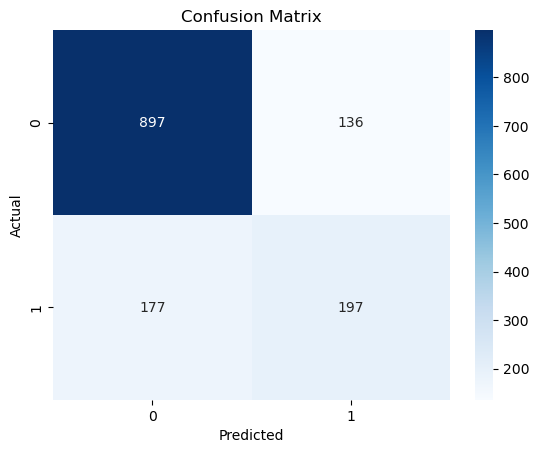

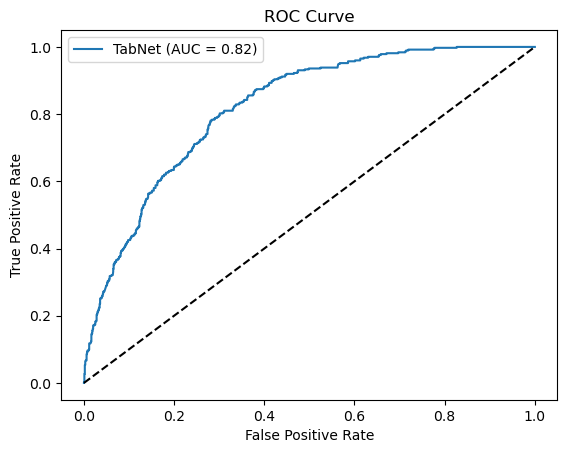

In [7]:
# Cell 7: Model Evaluation
y_pred = tabnet_model.predict(X_test_np) # 
y_proba = tabnet_model.predict_proba(X_test_np)[:,1]

print("Accuracy:", accuracy_score(y_test_np, y_pred)) # 
print("Precision:", precision_score(y_test_np, y_pred)) # 
print("Recall:", recall_score(y_test_np, y_pred)) # 
print("F1 Score:", f1_score(y_test_np, y_pred)) # 
print("ROC AUC:", roc_auc_score(y_test_np, y_proba)) # 
print("\nClassification Report:\n", classification_report(y_test_np, y_pred)) # [cite: 32, 33]

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_np, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_np, y_proba)
plt.plot(fpr, tpr, label='TabNet (AUC = {:.2f})'.format(roc_auc_score(y_test_np, y_proba)))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

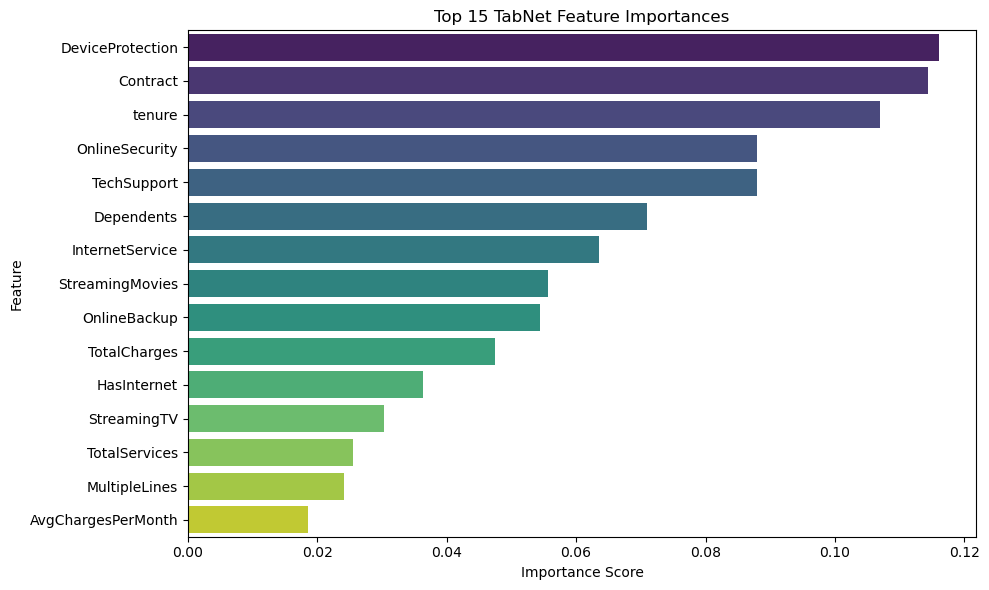

In [8]:
# Cell 8: Feature Importance Analysis
importances = tabnet_model.feature_importances_
features = X.columns
fi_df = pd.DataFrame({'feature': features, 'importance': importances})
fi_df = fi_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=fi_df.head(15), palette="viridis")
plt.title("Top 15 TabNet Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()